In [27]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from matplotlib.ticker import FuncFormatter

### Contexto
O crescimento dos supermercados nas cidades mais populosas está a aumentar e as competições de mercado também são elevadas. O conjunto de dados é um dos históricos de vendas de uma empresa supermercadista que registrou dados em 3 filiais diferentes durante 3 meses.

### Questões a serem desenvolvidas:

1. Performance por Filial:
Qual filial (A/B/C) teve o maior faturamento líquido? Há diferenças significativas entre elas?

2. Sazonalidade:
Existe padrão de vendas ao longo dos dias da semana ou horários? Como otimizar o escalonamento de funcionários?

3. Comportamento do Cliente:
Clientes com cartão de associado gastam mais que os normais? Qual o impacto no ticket médio?

4. Linhas de Produto:
"Quais linhas de produto têm maior margem bruta? Há diferença de preferência por gênero?

5. Métodos de Pagamento:
Qual método de pagamento é mais comum em cada cidade? Há relação com o valor total da compra?

6. Satisfação do Cliente:
A classificação (rating) está correlacionada com outras variáveis, como tempo de compra ou valor gasto?


In [3]:
# Importando a base de dados
df = pd.read_csv("supermarket_sales - Sheet1.csv")

#Verificando se há valores nulos
df.isnull().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

### 1. Performance por Filial:
Qual filial (A/B/C) teve o maior faturamento líquido? Há diferenças significativas entre elas?

Branch
C    110568.7065
A    106200.3705
B    106197.6720
Name: Total, dtype: float64


<Axes: xlabel='Branch'>

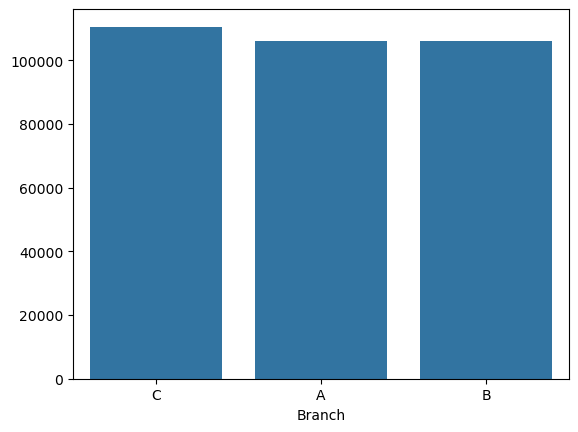

In [4]:
# Faturamento por filial
faturamento_por_filial = df.groupby("Branch")["Total"].sum().sort_values(ascending=False)
print(faturamento_por_filial)

sns.barplot(x=faturamento_por_filial.index, y=faturamento_por_filial.values)

In [5]:
# Realizando o Teste ANOVA, como temos 3 filiais e escolhemos o ANOVA para comparar as medias de faturamento por filial
filial_a = df[df["Branch"] == "A"]["Total"]
filial_b = df[df["Branch"] == "B"]["Total"]
filial_c = df[df["Branch"] == "C"]["Total"]

resultado_anova = stats.f_oneway(filial_a, filial_b, filial_c)
print(f'Estatística F: {resultado_anova.statistic}, p-valor: {resultado_anova.pvalue}')

Estatística F: 0.8845828327760512, p-valor: 0.413210174367147


#### Conclusão da Questão:
Podemos notar que não há uma diferença estatísticamente significativa entre cada uma das Filiais.

### 2. Sazonalidade:
Existe padrão de vendas ao longo dos dias da semana ou horários? Como otimizar o escalonamento de funcionários?

In [13]:
# Configurar o estilo dos gráficos
sns.set_theme(style="whitegrid")


# Converter colunas de data/hora
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.day_name()  # Extrair dia da semana em inglês
df['Hour'] = pd.to_datetime(df['Time']).dt.hour  # Extrair hora

# Ordenar dias da semana cronologicamente
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)

C:\Users\Kaique\AppData\Local\Temp\ipykernel_15168\2941848070.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour  # Extrair hora


C:\Users\Kaique\AppData\Local\Temp\ipykernel_15168\3855704839.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_sales = df.groupby('Weekday')['Total'].sum()
C:\Users\Kaique\AppData\Local\Temp\ipykernel_15168\3855704839.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


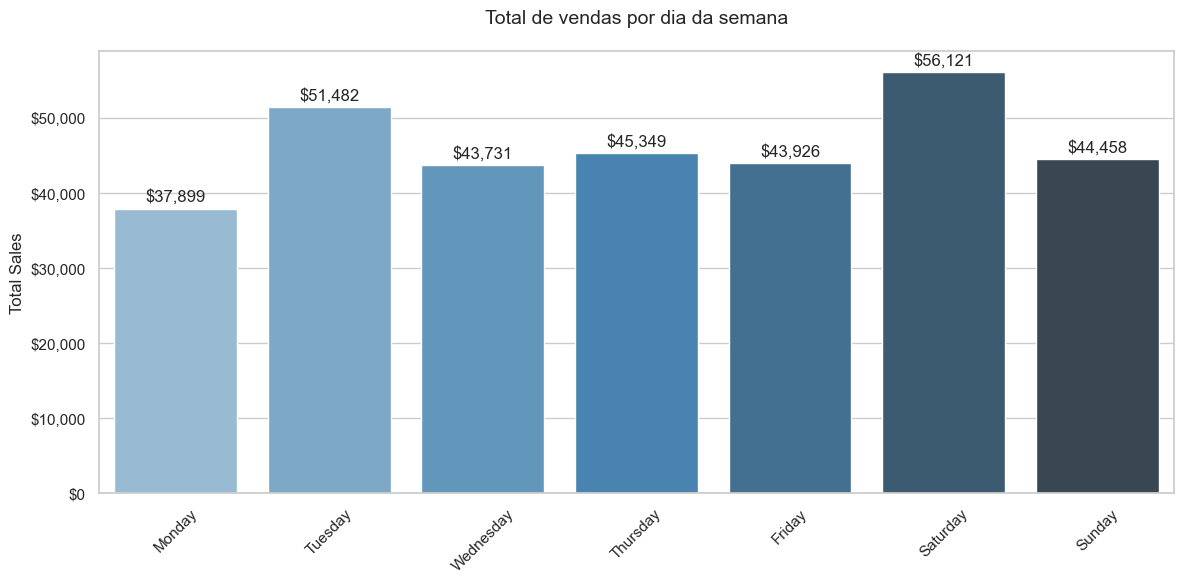

In [16]:
plt.figure(figsize=(12, 6))
daily_sales = df.groupby('Weekday')['Total'].sum()

# Formatar eixo Y em valores monetários
def currency_formatter(x, pos):
    return f'${x:,.0f}'

ax = sns.barplot(
    x=daily_sales.index, 
    y=daily_sales.values,
    palette="Blues_d",
    order=weekday_order
)

plt.title('Total de vendas por dia da semana', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Adicionar rótulos de valor
for p in ax.patches:
    ax.annotate(
        f'${p.get_height():,.0f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 9), 
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

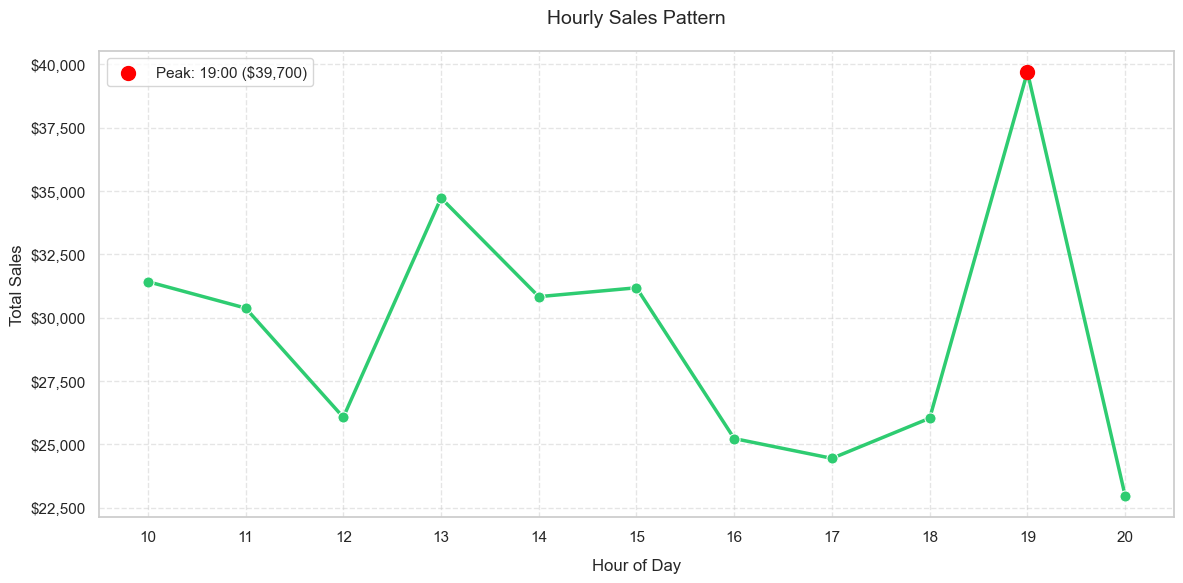

In [15]:
plt.figure(figsize=(12, 6))
hourly_sales = df.groupby('Hour')['Total'].sum()

ax = sns.lineplot(
    x=hourly_sales.index, 
    y=hourly_sales.values, 
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='#2ecc71'
)

plt.title('Hourly Sales Pattern', fontsize=14, pad=20)
plt.xlabel('Hour of Day', labelpad=10)
plt.ylabel('Total Sales')
plt.xticks(range(10, 21))  # Apenas horários com vendas (10h-21h)
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.grid(True, linestyle='--', alpha=0.5)

# Destacar pico de vendas
max_hour = hourly_sales.idxmax()
max_value = hourly_sales.max()
plt.scatter(
    max_hour, max_value, 
    color='red', 
    s=100, 
    zorder=5, 
    label=f'Peak: {max_hour}:00 (${max_value:,.0f})'
)

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Kaique\AppData\Local\Temp\ipykernel_15168\634713804.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sales_matrix = df.pivot_table(


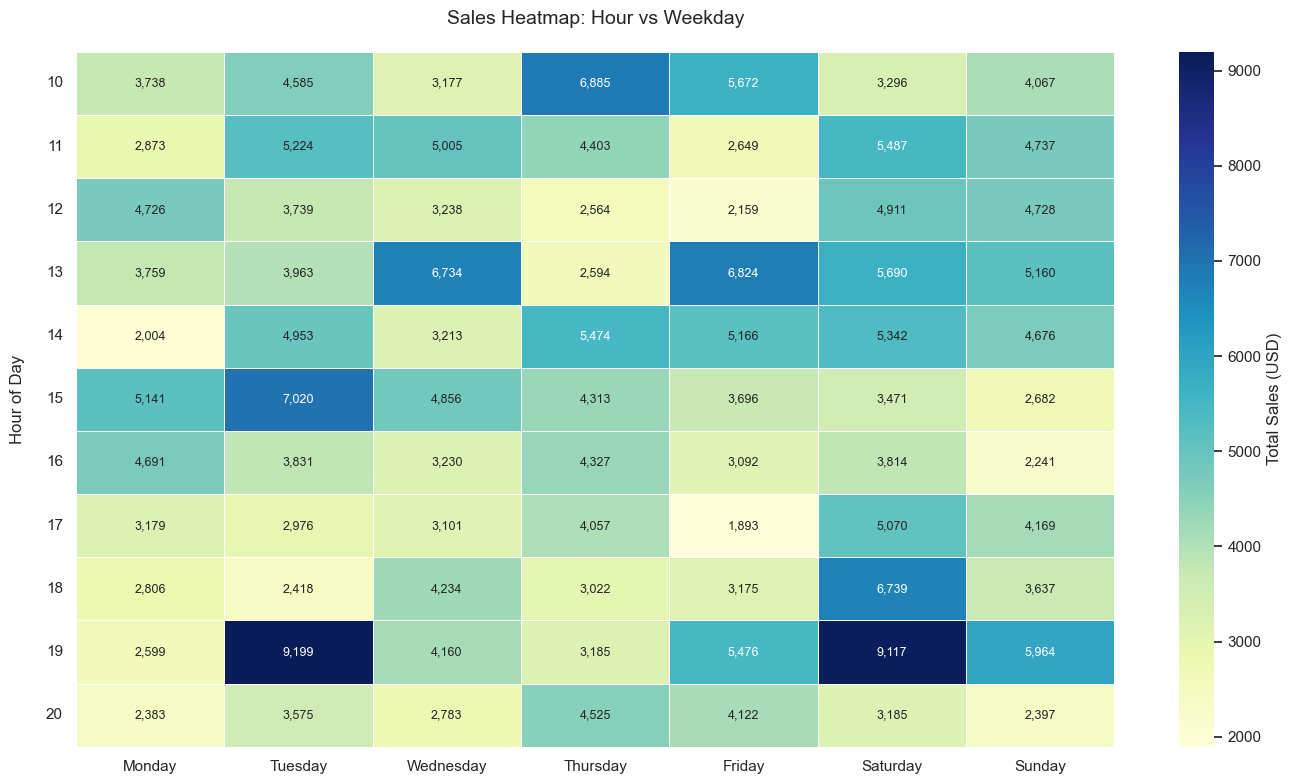

In [17]:
# Criar matriz de vendas
sales_matrix = df.pivot_table(
    index='Hour', 
    columns='Weekday', 
    values='Total', 
    aggfunc='sum'
)

# Plotar heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    sales_matrix, 
    cmap='YlGnBu',
    annot=True, 
    fmt=',.0f',
    linewidths=0.5,
    annot_kws={'size':9},
    cbar_kws={'label': 'Total Sales (USD)'}
)

plt.title('Sales Heatmap: Hour vs Weekday', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('Hour of Day', labelpad=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Conclusões:
 Podemos perceber que o horário mais lotado é as 19:00, tanto da Terça-feira, quanto do Sábado, são os dias mais lotados onde há um maior número de compras, de resto é mediano,com alguns picos de vendas não muito relevantes para que seja realmente nessesário o aumento de funcionários.

### 3. Comportamento do Cliente:
Clientes com cartão de associado gastam mais que os normais? Qual o impacto no ticket médio?

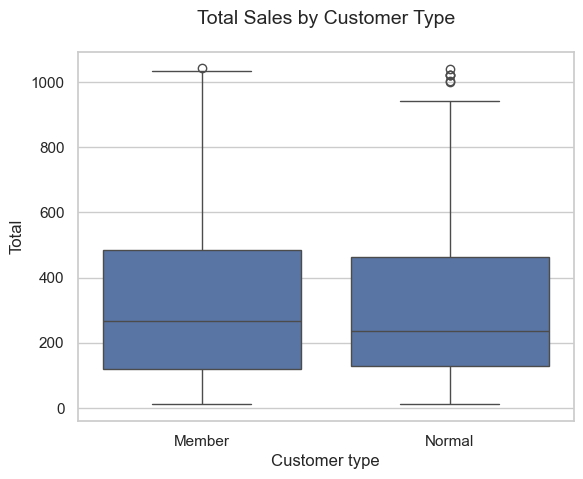

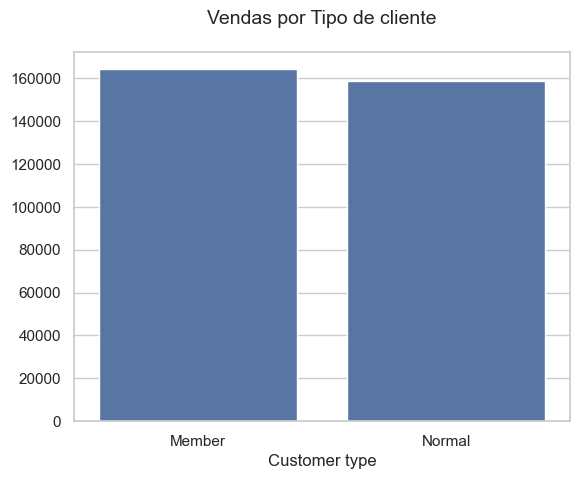

Customer type
Member    266.028
Normal    237.426
Name: Total, dtype: float64


In [25]:
tipo_do_cliente = df.groupby("Customer type")["Total"].sum().sort_values(ascending=False)

sns.boxplot(x="Customer type", y="Total", data=df)
plt.title('Total Sales by Customer Type', fontsize=14, pad=20)
plt.show()


sns.barplot(x=tipo_do_cliente.index, y=tipo_do_cliente.values)
plt.title("Vendas por Tipo de cliente", fontsize=14, pad=20)
plt.show()


# Definindo a média do ticket médio 
ticket_medio_por_cliente = df.groupby("Customer type")["Total"].median()
print(ticket_medio_por_cliente)

#### Conclusão:
Podemos concluir que não há pouca diferença no ticket médio dos membros e dos clientes normais, tanto como o número de clientes normais e membros

### 4. Linhas de Produto:
"Quais linhas de produto têm maior margem bruta? Há diferença de preferência por gênero?

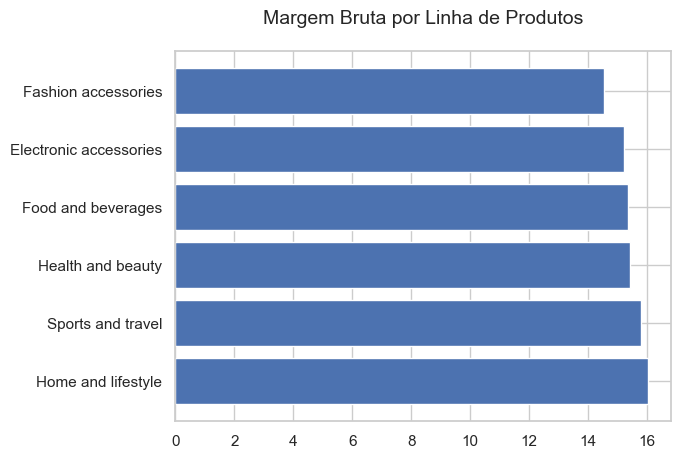

In [32]:
# Margem bruta por Linhas de produtos 
margem_bruta = df.groupby("Product line")["gross income"].mean().sort_values(ascending=False)
plt.barh(margem_bruta.index, margem_bruta.values)
plt.title("Margem Bruta por Linha de Produtos", fontsize=14, pad=20)
plt.show()

In [33]:
# Teste Qui-Quadrado para associação de gênero 
tabela_contingencia = pd.crosstab(df["Product line"], df["Gender"])
chi2, p, _, _ = chi2_contingency(tabela_contingencia)
print(f"p-valor: {p}")

p-valor: 0.331883858055391


Conclusões: Sobre a Margem bruta por linha de produto não há grandes diferenças, a linha com mais renda bruta é Home and Lifestyle, e com a realização do teste par a verificar se há associação de gênero por Linha de produto deu como resultado que não há associação de gênero por linha de produto.

### 5. Métodos de Pagamento:
Qual método de pagamento é mais comum em cada cidade? Há relação com o valor total da compra?

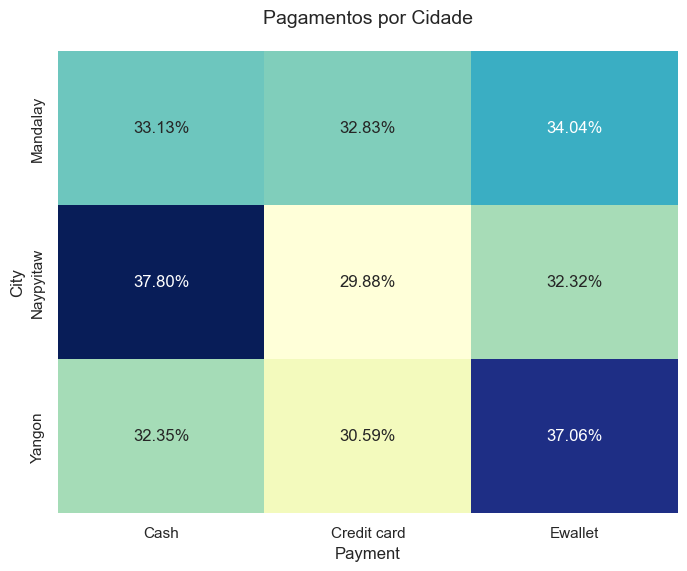

In [42]:
tabela_pagamento = pd.crosstab(df['City'], df['Payment'], normalize='index')
plt.figure(figsize=(8, 6))
sns.heatmap(tabela_pagamento, cmap='YlGnBu', annot=True, fmt='.2%', cbar=False)
plt.title('Pagamentos por Cidade', fontsize=14, pad=20)
plt.show()

#### Conclusão:
Podemos analisar que em todas as cidades os métodos de pagamento são bem distribuidos sem tipos de pagamento Preferenciais.

### 6. Satisfação do Cliente:
A classificação (rating) está correlacionada com outras variáveis, como tempo de compra ou valor gasto?

In [48]:
# Análise da Avaliação do cliente
# Verificar estatísticas básicas
print(df['Rating'].describe())      # Verificar média, mediana, mínimo, máximo

# Função para converter "HH:MM" para horas decimais
def time_to_decimal(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60

# Aplicar a função à coluna Time
df['Time_decimal'] = df['Time'].apply(time_to_decimal)

count    1000.00000
mean        6.97270
std         1.71858
min         4.00000
25%         5.50000
50%         7.00000
75%         8.50000
max        10.00000
Name: Rating, dtype: float64


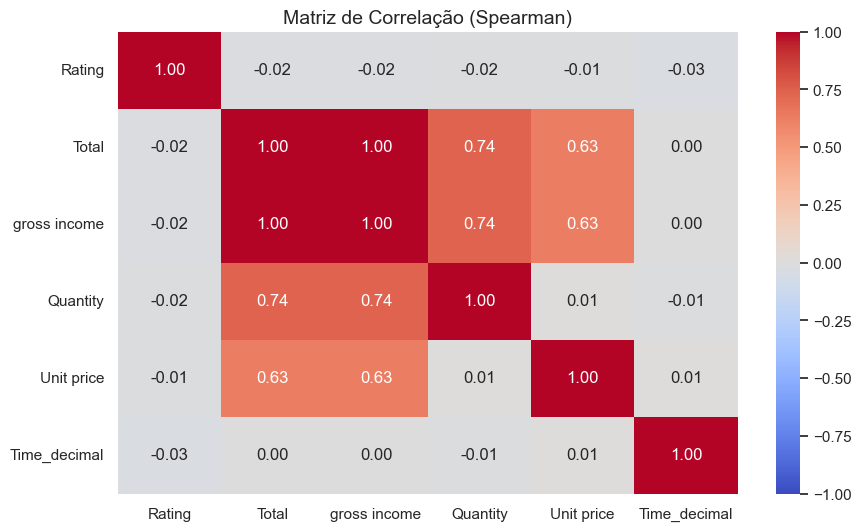

In [50]:
# Selecionar variáveis
variaveis = ['Rating', 'Total', 'gross income', 'Quantity', 'Unit price', 'Time_decimal']
df_corr = df[variaveis].corr(method='spearman')

# Plotar matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matriz de Correlação (Spearman)', fontsize=14)
plt.show()

#### Conclusão:
Não foi possivel encontrar uma correlação forte o sulficiente para ser considerada Relevante para A avaliação do cliente.